# LENSS Plotting Program

An important part of both research and outreach is providing a visualization of data. These visualizations allow quick comparisons between data sets which makes the process quicker as well as provide concrete evidence of work and progress to the general public.

This program is used for generating these plots. It pulls LENSS ARD_SQM data from your Drive, parses it, and creates a plot of the change in light over the course of a night along with some supplemental information about the night's conditions.

Originally written by: Kristin Baker 2021-08-19

Updated by: Alex Scerba 2022-06-20


## Installing and Importing Dependancies

Here we install the Python modules needed later on in the program and then import them for use.

We use pip3 to install the modules to the Colab instance we're running so that they can be imported.

In [ ]:
! pip3 install astroplan
! pip3 install astropy
! pip3 install julian

* `os` is used for system commands within the program.
* `matplotlib.pyplot` is how we generate plots of data.
* `astroplan` is used to find the time of various astronomical events.
* `astropy.units` makes it easier to use astronomical units needed it some lines of code.
* `astropy.time` provides an easy way to generate time data in various formats.
* `statistics` is used for performing some math opperations on the dataset.
* `datetime, timedelta, and date` are used for various system date and time operations.
* `julian` used for converting Modified Julian Dates.

In [ ]:
import os
import matplotlib.pyplot as plot
from astroplan import Observer
import astropy.units as astro_units
from astropy.time import Time
import statistics
from datetime import datetime, timedelta, date
import julian

## Linking With Drive

Google Colab allows easy Drive integration which is usefull since all LENSS data currently lives on Google Drive in the shared LENSS folder. Here, we import the required module and mount the Drive. Mine is set so that the shared LENSS folder is pinned in the 'My Drive' section of Google Drive. If yours is set in a different location, be sure to change that in the code as described in a later section.

**Note:** You will have to grant Colab permission to access your drive to continue.

    Currently under: `/LENSS/Data/Sensors Data`

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


## Getting Dates and Data Location

Because the ARD_SQM saves data on a per day basis, two files need to be opened to gather data for one night (evening data for the first and morning for the second). To get these, we need to know the dates and locations of each of the files as well as the sensor number.

### Date Selection

Here we select the files to be used based on today's date. By default, the program selects a date two days back and a date one day back. To more easily select a date farther into the past or possibly test data set in the future, a `date_offset_override` variable was included.

    Usage: Ex. Date 2022-06-10

    date_offset_override = 0    # Default value. Would Select 2022-06-08 and 2022-06-09
    date_offset_override = -5   # Would select 2022-06-02 and 2022-06-03

In [ ]:
today = date.today()
date_offset_override = (
    -10
)  # For manually selecting a date. Negative goes back in time, positive goes forward. 0 is the previous night; EX: today is 6/12/2022 then 0 would mean data from the evening of 6/10/2022 and morning of 6/11/2022
print("Today's date: " + str(today))

evening_date = today - timedelta(days=2 - date_offset_override)
evening_year_and_month = evening_date.strftime("%Y-%m")
print("Evening date: " + str(evening_date))

morning_date = today - timedelta(days=1 - date_offset_override)
morning_year_and_month = morning_date.strftime("%Y-%m")
print("Morning date: " + str(morning_date))

Today's date: 2022-06-20
Evening date: 2022-06-08
Morning date: 2022-06-09


### Setting Data Location

Currently, files are sorted in the format: `YYYY-MM/LENSS_TSL_0000/YYYY-MM-DD_LENSSTSL_0000.txt`. The below code looks at the path and sensor number set and generates the file paths for the two data files to be used in the next step.

The default value for `parent_directory` will work if you have the shared LENSS folder pinned/stared so that it shows up under the 'My Drive' section of your Drive. **If the LENSS folder is only under your 'Shared with me' section**, make sure to star the folder so that it appears in your Drive. If you have the LENSS folder stared and it is under another folder in your Drive, make sure to modify the `parent_directory` variable to reflect the path difference.

    Usage:
      Ex. LENSS folder located at 'My Drive/GLAS_Folder/LENSS'
        parent_directory = '/content/drive/MyDrive/GLAS_Folder/LENSS/Data/Sensors Data'
      Ex. Sensor number 32
        sensor_number = '0032'

In [ ]:
parent_directory = "/content/drive/MyDrive/LENSS/Data/Sensors Data"
sensor_number = "0010"  # Grab from dir or filename in the future

sensor_name = "Sensor " + sensor_number.lstrip("0")

evening_file_path = (
    parent_directory
    + "/"
    + evening_year_and_month
    + "/LENSS_TSL_"
    + sensor_number
    + "/"
    + str(evening_date)
    + "_LENSSTSL"
    + sensor_number
    + ".txt"
)
morning_file_path = (
    parent_directory
    + "/"
    + morning_year_and_month
    + "/LENSS_TSL_"
    + sensor_number
    + "/"
    + str(morning_date)
    + "_LENSSTSL"
    + sensor_number
    + ".txt"
)

print(sensor_name)
print(evening_file_path)
print(morning_file_path)

Sensor 10
/content/drive/MyDrive/LENSS/Data/Sensors Data/2022-06/LENSS_TSL_0010/2022-06-08_LENSSTSL0010.txt
/content/drive/MyDrive/LENSS/Data/Sensors Data/2022-06/LENSS_TSL_0010/2022-06-09_LENSSTSL0010.txt


## Importing the Data

Here, we define a set of arrays to store each kind of data point in both files. The files are split to facilitate easier selection of the start and stop points for each day. There is probably a more efficient way to handle this.

The files are read line-by-line, and the data is split at each comma in the line. The datapoint is then put into the cooresponding array for later use.

In [ ]:
evening_time = []
morning_time = []
evening_temp = []
morning_temp = []
evening_voltage = []
morning_voltage = []
evening_frequency = []
morning_frequency = []
evening_time1 = []
morning_time1 = []

evening_file = open(evening_file_path, "r")
data_set = evening_file.readlines()

for line in data_set:
    evening_time.append(str(line.split(",")[0]))
    evening_voltage.append(float(line.split(",")[1]))
    evening_frequency.append(float(line.split(",")[2]))
    evening_temp.append(float(line.split(",")[3]))

for number in range(len(evening_time)):
    evening_time1.append(str(evening_date) + "T" + evening_time[number])

evening_file.close()

morning_file = open(morning_file_path, "r")
data_set = morning_file.readlines()

for line in data_set:
    morning_time.append(str(line.split(",")[0]))
    morning_voltage.append(float(line.split(",")[1]))
    morning_frequency.append(float(line.split(",")[2]))
    morning_temp.append(float(line.split(",")[3]))

for number in range(len(morning_time)):
    morning_time1.append(str(morning_date) + "T" + morning_time[number])

morning_file.close()

## Modified Julian Dates

A good explination of what Modified Julian Dates are can be found [here](https://core2.gsfc.nasa.gov/time/) on NASA's site.

Here, we create arrays of MJD timestamps that coorespond to the local times in each file. We use the MJD timestamps to select each twilight time without worrying about daylight savings time.

**Note:** Will be depreciated with the addition of UTC timestamps to the datafiles.


In [ ]:
evening_mjd_time = []
morning_mjd_time = []

local_mjd_1 = Time(evening_time1, format="isot", scale="local").mjd

for number in range(len(evening_time1)):
    evening_mjd_time.append(local_mjd_1[number])

local_mjd_2 = Time(morning_time1, format="isot", scale="local").mjd

for number in range(len(morning_time1)):
    morning_mjd_time.append(local_mjd_2[number])

## Finding Twilight and Moon Phases

To find twilight and moon phases, we use the Astroplan library's Observer object which will generate values based on the location and general time of observation.

Currently, the general values for observation time are 4:00 pm and 5:00 am, but exact MJD values are generated from the Observer object.

    Moon Illumination and Phase:

    0 = new moon
    0 - .5 = cresent
    .5 = quarter
    .501 - 1 = gibbous
    1 = full moon


In [ ]:
sensor_location = Observer(
    longitude=-88.5375518 * astro_units.deg,
    latitude=42.587277 * astro_units.deg,
    elevation=879 * astro_units.m,
)

evening_twilight = str(evening_date) + " 16:00:00.000"
morning_twilight = str(morning_date) + " 05:00:00.000"
evening_value = (
    float(
        str(
            sensor_location.twilight_evening_astronomical(
                Time(evening_twilight)
            )
        )
    )
    - 2400000.5
    - (6 * (0.5 / 12))
)
morning_value = (
    float(
        str(
            sensor_location.twilight_morning_astronomical(
                Time(morning_twilight)
            )
        )
    )
    - 2400000.5
    - (6 * (0.5 / 12))
)
moon_value = float(str(sensor_location.moon_illumination(evening_twilight)))
moon_phase = []

if moon_value == 0:
    moon_phase.append("New Moon")
elif (moon_value > 0) and (moon_value < 0.5):
    moon_phase.append("Cresent")
elif moon_phase == 0.5:
    moon_phase.append("Quarter")
elif (moon_value > 0.5) and (moon_value < 1):
    moon_phase.append("Gibbous")
elif moon_phase == 1:
    moon_phase.append("Full")

print(moon_phase[0])

Gibbous


## Cutting Unnecessary Data

Here we compare the MJD time array to the found values for evening and morning twilight, and if the data is in between those times it is added to the appropriate array. The arrays are then combined to create a master data set.

Lastly, 24 hour times are converted to 12 hour times.

In [ ]:
local_time = []
mjd_time = []
temp = []
voltage = []

mjd_evening1 = []
evening_frequency1 = []

evening_temp1 = []
morning_temp1 = []

evening_voltage1 = []
morning_voltage1 = []

mjd_morning1 = []
morning_frequency1 = []

local_time1 = []
local_time2 = []

for i in range(len(evening_mjd_time)):
    if evening_mjd_time[i] >= evening_value:
        mjd_evening1.append(evening_mjd_time[i])
        evening_frequency1.append(evening_frequency[i])
        local_time1.append(evening_time[i])
        evening_temp1.append(evening_temp[i])
        evening_voltage1.append(evening_voltage[i])

for i in range(len(morning_mjd_time)):
    if morning_mjd_time[i] <= morning_value:
        mjd_morning1.append(morning_mjd_time[i])
        morning_frequency1.append(morning_frequency[i])
        local_time2.append(morning_time[i])
        morning_temp1.append(morning_temp[i])
        morning_voltage1.append(morning_voltage[i])

frequency = evening_frequency1 + morning_frequency1
mjd_time = mjd_evening1 + mjd_morning1
local_time = local_time1 + local_time2
temp = evening_temp1 + morning_temp1
voltage = evening_voltage1 + morning_voltage1

local_12time = []

# convert local_time array from strings in 24 time to string objects in 12 hour time
for i in range(len(local_time)):
    x1 = local_time[i]
    x2 = datetime.strptime(x1, "%H:%M:%S")
    local_12time.append(x2.strftime("%I:%M %p"))

## Sun and Moon Rising and Setting

Here we find the times for sunset, sunrise, moonset, and moonrise for displaying later on the plot.

In [ ]:
sunset_mjd_time = (
    float(
        str(
            sensor_location.sun_set_time(
                Time(evening_twilight), which="nearest"
            )
        )
    )
    - 2400000.5
    - (6 * (0.5 / 12))
)
sunset_standard_time = julian.from_jd(sunset_mjd_time, fmt="mjd")
sunset_24time = sunset_standard_time.strftime(("%H:%M"))
sunset_12time = sunset_standard_time.strftime("%m-%d-%y %I:%M %p")

sunrise_mjd_time = (
    float(
        str(
            sensor_location.sun_rise_time(
                Time(morning_twilight), which="nearest"
            )
        )
    )
    - 2400000.5
    - (6 * (0.5 / 12))
)
sunrise_standard_time = julian.from_jd(sunrise_mjd_time, fmt="mjd")
sunrise_24time = sunrise_standard_time.strftime(("%H:%M"))
sunrise_12time = sunrise_standard_time.strftime("%m-%d-%y %I:%M %p")

moonrise_mjd_time = (
    float(
        str(
            sensor_location.moon_rise_time(
                Time(evening_twilight), which="nearest"
            )
        )
    )
    - 2400000.5
    - (6 * (0.5 / 12))
)
moonrise_standard_time = julian.from_jd(moonrise_mjd_time, fmt="mjd")
moonrise_24time = moonrise_standard_time.strftime(("%H:%M"))
moonrise_12time = moonrise_standard_time.strftime("%m-%d-%y %I:%M %p")

moonset_mjd_time = (
    float(
        str(
            sensor_location.moon_set_time(
                Time(morning_twilight), which="nearest"
            )
        )
    )
    - 2400000.5
    - (6 * (0.5 / 12))
)
moonset_standard_time = julian.from_jd(moonset_mjd_time, fmt="mjd")
moonset_24time = moonset_standard_time.strftime(("%H:%M"))
moonset_12time = moonset_standard_time.strftime("%m-%d-%y %I:%M %p")

## Mean and Median Datapoints

Here we calculate the mean and median for the dataset to be displayed on the plot.

In [ ]:
min_frequency = float(min(frequency))
y_min = min_frequency - 10

max_frequency = float(max(frequency))
y_max = max_frequency + 10

mean_freq = str(round((sum(frequency) / len(frequency)), 2))
median_freq = str(round(statistics.median(frequency), 2))

## Plotting the Data

Here we generate a plot of sensor data over time and overlay some supplementary data such as sunset and sunrise. 

The plot is then saved as a 72 dpi image in PNG format for use on the web.

**Note:** The plots folder location as set in `figure.savefig()` should be changed to a more permanent location.

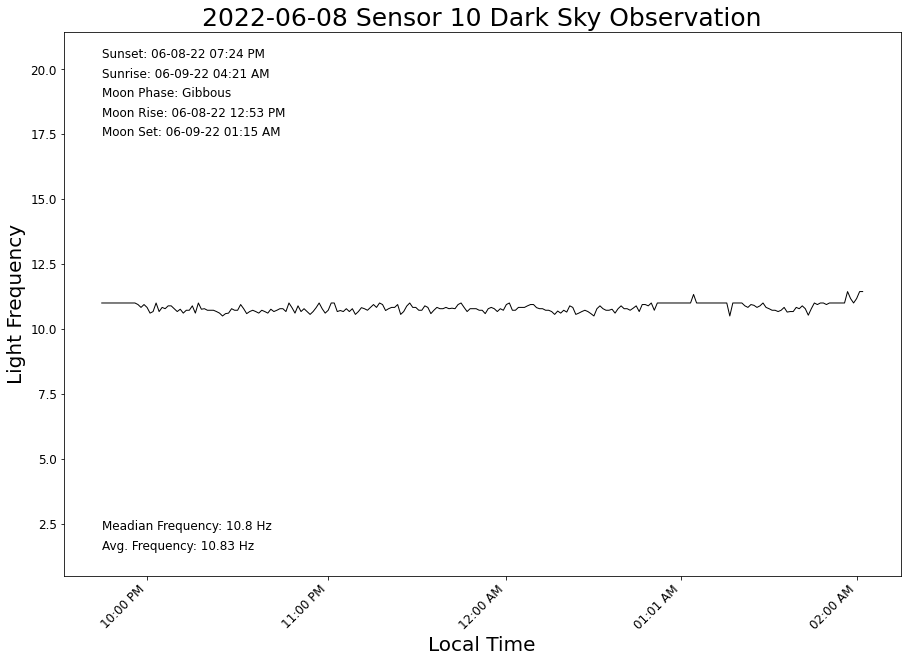

In [ ]:
figure = plot.figure(figsize=(15, 10))

plot.title(
    str(evening_date) + " " + sensor_name + " Dark Sky Observation", fontsize=25
)

plot.plot(local_12time, frequency, color="k", linewidth=1)

plot.ylabel("Light Frequency", fontsize=20)
plot.yticks(fontsize=12)
plot.ylim(y_min, y_max)

plot.xlabel("Local Time", fontsize=20)
plot.xticks(
    ["10:00 PM", "11:00 PM", "12:00 AM", "01:01 AM", "02:00 AM"], fontsize=12
)
plot.xticks(rotation=45, ha="right")

# Supplementary Data
plot.text(local_12time[0], y_max - 1, "Sunset: " + sunset_12time, fontsize=12)
plot.text(
    local_12time[0], y_max - 1.75, "Sunrise: " + sunrise_12time, fontsize=12
)
plot.text(
    local_12time[0], y_max - 2.5, "Moon Phase: " + moon_phase[0], fontsize=12
)
plot.text(
    local_12time[0], y_max - 3.25, "Moon Rise: " + moonrise_12time, fontsize=12
)
plot.text(
    local_12time[0], y_max - 4, "Moon Set: " + moonset_12time, fontsize=12
)
plot.text(
    local_12time[0],
    y_min + 1,
    "Avg. Frequency: " + mean_freq + " Hz",
    fontsize=12,
)
plot.text(
    local_12time[0],
    y_min + 1.75,
    "Meadian Frequency: " + median_freq + " Hz",
    fontsize=12,
)

figure.savefig(
    "drive/MyDrive/LENSS/Data/Data Analysis/PLOTS_TEST/"
    + str(evening_date)
    + "_LENSSTSL"
    + sensor_number
    + "_Plot.png",
    transparent=False,
    dpi=72,
    bbox_inches="tight",
)
plot.show()